In [87]:
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import style
pd.set_option('display.float_format', lambda x: '%.2f' % x)
style.use('ggplot')
% matplotlib inline

### xirr function for performance comparison 

In [189]:
def xnpv(rate, values, dates):
    '''Equivalent of Excel's XNPV function. Found on Stack Overflow
    >>> from datetime import date
    >>> dates = [date(2010, 12, 29), date(2012, 1, 25), date(2012, 3, 8)]
    >>> values = [-10000, 20, 10100]
    >>> xnpv(0.1, values, dates)
    -966.4345...
    '''
    if rate <= -1.0:
        return float('inf')
    d0 = dates[0]    # or min(dates)
    print(rate)
    return sum([ vi / (1.0 + rate)**((di - d0).days / 365.0) for vi, di in zip(values, dates)])

def xirr(values, dates):
    '''Equivalent of Excel's XIRR function. Found on Stack Overflow
    >>> from datetime import date
    >>> dates = [date(2010, 12, 29), date(2012, 1, 25), date(2012, 3, 8)]
    >>> values = [-10000, 20, 10100]
    >>> xirr(values, dates)
    0.0100612...
    '''
    try:
        return scipy.optimize.newton(lambda r: xnpv(r, values, dates), 0.0)
    except RuntimeError:    # Failed to converge?
        return scipy.optimize.brentq(lambda r: xnpv(r, values, dates), -1.0, 1e10)

### Investment contions 

In [183]:
initial_inv = -10000.0
quarterly_contribution = -2500.0

### Quotes download: 

In [90]:
def quotes_df(ticker, start, end):
    '''
    Downloads quotes in csv and loads into pandas DataFrame
    ticker - 'APPL'
    start - 'YYYYMMDD'
    end - 'YYYYMMDD"
    '''
    url = "".join(("https://stooq.pl/q/d/l/?s=", ticker, "&d1=", start, "&d2=", end, "&i=d"))
    df = pd.read_csv(url)
    df = df[['Data','Zamkniecie']]
    df['Data'] = pd.to_datetime(df["Data"], format='%Y-%m-%d')
    df.set_index('Data', inplace=True)
    df.rename(columns={'Zamkniecie':'Price'}, inplace=True)
    return df

# Study 1: Bull Market

### Stock performance visualisation 

In [91]:
quotes = quotes_df('^SPX', '20120101', '20180101')

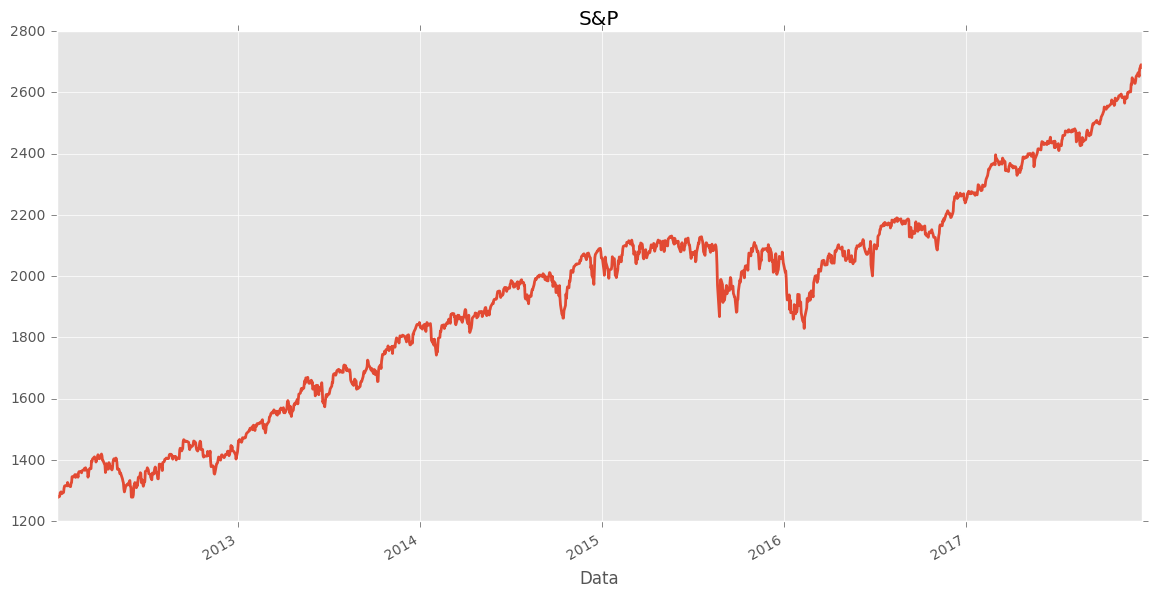

In [104]:
ax = quotes.plot(figsize=(14,7), linewidth=2, legend=False, title = 'S&P');

### Dollar Cost Averaging DataFrame:

In [134]:
dca_df = quotes.asfreq(freq='Q',method='ffill')
dca_df['DCA_contr'] = initial_inv
dca_df.iloc[1:,1] = quarterly_contribution
dca_df['DCA_cum_inv'] = dca_df['DCA_contr'].cumsum()
dca_df['DCA_shares_bought'] = -dca_df['DCA_contr']/dca_df.iloc[:,0]
dca_df['DCA_cum_shares'] = dca_df['DCA_shares_bought'].cumsum()
dca_df['DCA_Total_Val'] = dca_df['DCA_cum_shares'] * dca_df.iloc[:,0]
dca_df['DCA_avg_price'] = -dca_df['DCA_cum_inv'] / dca_df['DCA_cum_shares']
values = list(dca_df['DCA_contr'])
values.append(dca_df['DCA_Total_Val'][-1])
dates = list(dca_df.index)
dates.append(dca_df.index[-1])
dca_xirr = (str(round(xirr(values, dates)*100,1))+"%")
dca_df

,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price
Data,,,,,,,
2012-03-31,1408.47,-10000,-10000,7.10,7.10,10000.00,1408.47
2012-06-30,1362.16,-2500,-12500,1.84,8.94,12171.20,1398.96
2012-09-30,1440.67,-2500,-15000,1.74,10.67,15372.71,1405.74
2012-12-31,1426.19,-2500,-17500,1.75,12.42,17718.20,1408.63
2013-03-31,1569.19,-2500,-20000,1.59,14.02,21994.75,1426.88
2013-06-30,1606.28,-2500,-22500,1.56,15.57,25014.63,1444.81
2013-09-30,1681.55,-2500,-25000,1.49,17.06,28686.81,1465.44
2013-12-31,1848.36,-2500,-27500,1.35,18.41,34032.55,1493.57
2014-03-31,1872.34,-2500,-30000,1.34,19.75,36974.07,1519.18


### Value Averaging DataFrame

In [140]:
va_df = quotes.asfreq(freq='Q',method='ffill')
va_df['VA_target'] = initial_inv
va_df.iloc[1:,1] = quarterly_contribution
va_df['VA_target_cum'] = va_df['VA_target'].cumsum()
va_df['VA_target_shares'] = -va_df['VA_target']/va_df.iloc[:,0]

va_df.loc[quart_val.index[0],'VA_contr'] = initial_inv
va_df.loc[quart_val.index[0],'VA_shares_bought'] = -initial_inv/va_df.iloc[:,0][0]
va_df.loc[quart_val.index[0],'VA_cum_shares'] = va_df['VA_shares_bought'][0]

n = 0
for i, row in va_df.iterrows():
    cur_target = va_df['VA_target_cum'][i]
    prev_cum = va_df['VA_cum_shares'][n-1]
    cur_price = va_df.iloc[:,0][i]
    n += 1
    if i == va_df.index[0]:
        continue
    else:
        cur_cont = cur_target + (prev_cum * cur_price)
        cur_shares = -cur_cont / cur_price
        va_df.loc[i,'VA_contr'] = cur_cont
        va_df.loc[i, 'VA_shares_bought'] = cur_shares
        va_df.loc[i, 'VA_cum_shares'] = prev_cum + cur_shares
                                    
va_df['VA_cum_inv'] = va_df['VA_contr'].cumsum()
va_df['VA_Total_Val'] = va_df['VA_cum_shares'] * va_df.iloc[:,0]
va_df['VA_avg_price'] = -va_df['VA_cum_inv'] / va_df['VA_cum_shares']
values = list(va_df['VA_contr'])
values.append(va_df['VA_Total_Val'][-1])
dates = list(va_df.index)
dates.append(va_df.index[-1])
va_xirr = (str(round(xirr(values, dates)*100,1))+"%")
va_df = va_df[['Price', 'VA_contr', 'VA_cum_inv', 'VA_shares_bought','VA_cum_shares','VA_Total_Val', 'VA_avg_price']]
va_df

,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price
Data,,,,,,,
2012-03-31,1408.47,-10000.00,-10000.00,7.10,7.10,10000.00,1408.47
2012-06-30,1362.16,-2828.80,-12828.80,2.08,9.18,12500.00,1397.99
2012-09-30,1440.67,-1779.54,-14608.34,1.24,10.41,15000.00,1403.05
2012-12-31,1426.19,-2650.76,-17259.10,1.86,12.27,17500.00,1406.56
2013-03-31,1569.19,-745.32,-18004.43,0.47,12.75,20000.00,1412.62
2013-06-30,1606.28,-2027.27,-20031.70,1.26,14.01,22500.00,1430.07
2013-09-30,1681.55,-1445.65,-21477.36,0.86,14.87,25000.00,1444.61
2013-12-31,1848.36,-20.00,-21497.35,0.01,14.88,27500.00,1444.90
2014-03-31,1872.34,-2143.22,-23640.58,1.14,16.02,30000.00,1475.44


### Results comparison

In [151]:
summary = [['Final Value', dca_df['DCA_Total_Val'][-1], va_df['VA_Total_Val'][-1]],
          ['Tolat Invested', dca_df['DCA_cum_inv'][-1], va_df['VA_cum_inv'][-1]],
          ['Avg share price', dca_df['DCA_avg_price'][-1], va_df['VA_avg_price'][-1]],
          ['XIRR', dca_xirr, va_xirr]]

comparison = pd.DataFrame(summary, columns=['Measure', 'DCA', 'VA'])
comparison = comparison.set_index('Measure')
comparison

,DCA,VA
Measure,,
Final Value,91218.81,65000.00
Tolat Invested,-65000,-43427.04
Avg share price,1795.23,1683.21
XIRR,11.0%,11.3%


# Study 2: Bear Market

### Stock performance visualisation 

In [152]:
quotes = quotes_df('CHK.US', '20120101', '20180101')

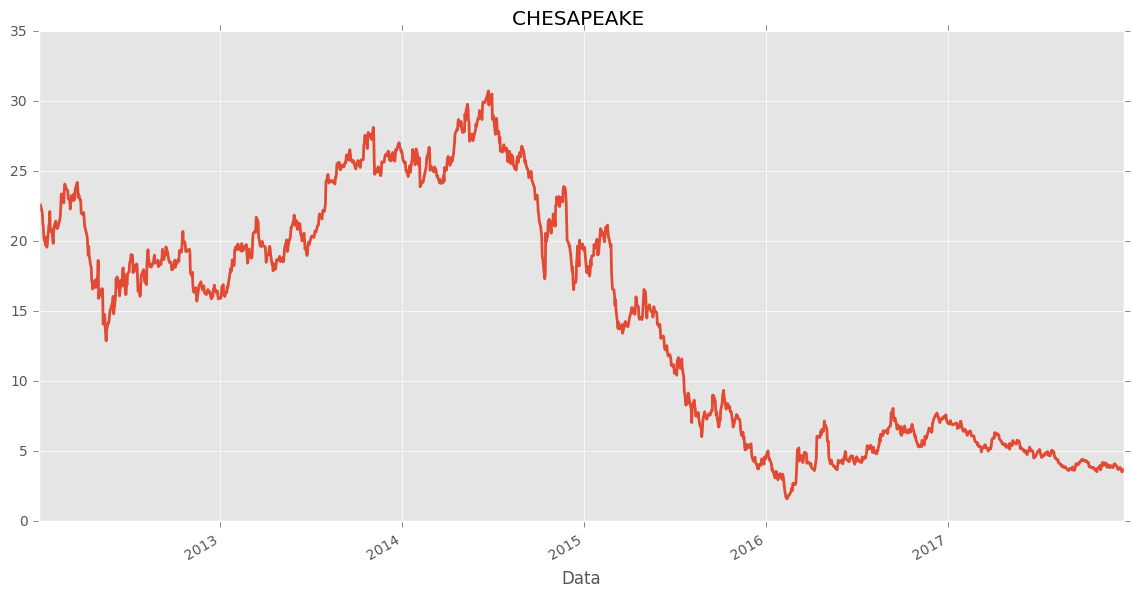

In [154]:
ax = quotes.plot(figsize=(14,7), linewidth=2, legend=False, title = 'CHESAPEAKE ');

### Dollar Cost Averaging DataFrame:

In [194]:
dca_df = quotes.asfreq(freq='Q',method='ffill')
dca_df['DCA_contr'] = initial_inv
dca_df.iloc[1:,1] = quarterly_contribution
dca_df['DCA_cum_inv'] = dca_df['DCA_contr'].cumsum()
dca_df['DCA_shares_bought'] = -dca_df['DCA_contr']/dca_df.iloc[:,0]
dca_df['DCA_cum_shares'] = dca_df['DCA_shares_bought'].cumsum()
dca_df['DCA_Total_Val'] = dca_df['DCA_cum_shares'] * dca_df.iloc[:,0]
dca_df['DCA_avg_price'] = -dca_df['DCA_cum_inv'] / dca_df['DCA_cum_shares']
values = list(dca_df['DCA_contr'])
values.append(dca_df['DCA_Total_Val'][-1])
dates = list(dca_df.index)
dates.append(dca_df.index[-1])
dca_xirr = xirr(values, dates)
print(dca_xirr)
dca_df

0.0
0.0001
8.97232066738
13.9562167624
113.533334554
859.007379618
15631.4460492
487916.36262
32800926.104
5002961637.41
2.05391131669e+12
2.75341339907e+15
1.54841964646e+19
4.95272838428e+23
1.30382008365e+29
4.41101799144e+35
3.27955411283e+43
1.02177861851e+53
2.90029293605e+64
1.89815821853e+78
9.49079109265e+77


C:\Users\Przemek\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Przemek\Anaconda3\lib\site-packages\scipy\optimize\zeros.py:173: RuntimeWarning: Tolerance of 1.89815821853e+78 reached
  warnings.warn(msg, RuntimeWarning)


,Price,DCA_contr,DCA_cum_inv,DCA_shares_bought,DCA_cum_shares,DCA_Total_Val,DCA_avg_price
Data,,,,,,,
2012-03-31,21.91,-10000.00,-10000.00,456.33,456.33,10000.00,21.91
2012-06-30,17.67,-2500.00,-12500.00,141.49,597.82,10562.88,20.91
2012-09-30,18.01,-2500.00,-15000.00,138.83,736.65,13265.54,20.36
2012-12-31,15.93,-2500.00,-17500.00,156.92,893.56,14236.26,19.58
2013-03-31,19.67,-2500.00,-20000.00,127.11,1020.67,20074.62,19.59
2013-06-30,19.73,-2500.00,-22500.00,126.74,1147.42,22632.80,19.61
2013-09-30,25.15,-2500.00,-25000.00,99.41,1246.82,31356.39,20.05
2013-12-31,26.46,-2500.00,-27500.00,94.47,1341.30,35494.71,20.50
2014-03-31,25.07,-2500.00,-30000.00,99.73,1441.03,36122.26,20.82


### Value Averaging DataFrame

In [196]:
va_df = quotes.asfreq(freq='Q',method='ffill')
va_df['VA_target'] = initial_inv
va_df.iloc[1:,1] = quarterly_contribution
va_df['VA_target_cum'] = va_df['VA_target'].cumsum()
va_df['VA_target_shares'] = -va_df['VA_target']/va_df.iloc[:,0]

va_df.loc[quart_val.index[0],'VA_contr'] = initial_inv
va_df.loc[quart_val.index[0],'VA_shares_bought'] = -initial_inv/va_df.iloc[:,0][0]
va_df.loc[quart_val.index[0],'VA_cum_shares'] = va_df['VA_shares_bought'][0]

n = 0
for i, row in va_df.iterrows():
    cur_target = va_df['VA_target_cum'][i]
    prev_cum = va_df['VA_cum_shares'][n-1]
    cur_price = va_df.iloc[:,0][i]
    n += 1
    if i == va_df.index[0]:
        continue
    else:
        cur_cont = cur_target + (prev_cum * cur_price)
        cur_shares = -cur_cont / cur_price
        va_df.loc[i,'VA_contr'] = cur_cont
        va_df.loc[i, 'VA_shares_bought'] = cur_shares
        va_df.loc[i, 'VA_cum_shares'] = prev_cum + cur_shares
                                    
va_df['VA_cum_inv'] = va_df['VA_contr'].cumsum()
va_df['VA_Total_Val'] = va_df['VA_cum_shares'] * va_df.iloc[:,0]
va_df['VA_avg_price'] = -va_df['VA_cum_inv'] / va_df['VA_cum_shares']
values = list(va_df['VA_contr'])
values.append(va_df['VA_Total_Val'][-1])
dates = list(va_df.index)
dates.append(va_df.index[-1])
va_xirr = (str(round(xirr(values, dates)*100,1))+"%")
print(va_xirr)
va_df = va_df[['Price', 'VA_contr', 'VA_cum_inv', 'VA_shares_bought','VA_cum_shares','VA_Total_Val', 'VA_avg_price']]
va_df

0.0
0.0001
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
10000000000.0
9999999999.999996
4999999999.499998
2499999999.249999
1249999999.1249995
624999999.0624998
312499999.0312499
156249999.01562494
78124999.00781247
39062499.003906235
19531249.001953118
9765624.000976559
4882811.500488279
2441405.2502441397
1220702.1251220698
610350.5625610349
305174.78128051746
152586.89064025873
76292.94532012937
38145.97266006468
19072.48633003234
9535.74316501617
4767.371582508085
2383.1857912540427
1191.0928956270213
595.0464478135107
297.02322390675533
148.01161195337767
73.50580597668883
36.25290298834442
17.62645149417221
8.313225747086104
3.656612873543052
1.328306436771526
0.16415321838576302
-0.4179233908071185
0.10933537698416834
-0.15429400691147505
-0.2861086988592968
-0.2090309292917472
-0.23941316760957226
-0.2329290600021832
-0.233753252

C:\Users\Przemek\Anaconda3\lib\site-packages\scipy\optimize\zeros.py:176: RuntimeWarning: invalid value encountered in double_scalars
  p = p1 - q1*(p1 - p0)/(q1 - q0)


,Price,VA_contr,VA_cum_inv,VA_shares_bought,VA_cum_shares,VA_Total_Val,VA_avg_price
Data,,,,,,,
2012-03-31,21.91,-10000.00,-10000.00,456.33,456.33,10000.00,21.91
2012-06-30,17.67,-4437.12,-14437.12,251.12,707.45,12500.00,20.41
2012-09-30,18.01,-2260.17,-16697.29,125.51,832.96,15000.00,20.05
2012-12-31,15.93,-4229.23,-20926.52,265.46,1098.42,17500.00,19.05
2013-03-31,19.67,1603.69,-19322.83,-81.54,1016.88,20000.00,19.00
2013-06-30,19.73,-2442.04,-21764.87,123.80,1140.68,22500.00,19.08
2013-09-30,25.15,3687.07,-18077.80,-146.61,994.08,25000.00,18.19
2013-12-31,26.46,-1193.79,-19271.58,45.11,1039.19,27500.00,18.54
2014-03-31,25.07,-3950.70,-23222.29,157.61,1196.79,30000.00,19.40


### Results comparison

In [172]:
summary = [['Final Value', dca_df['DCA_Total_Val'][-1], va_df['VA_Total_Val'][-1]],
          ['Tolat Invested', dca_df['DCA_cum_inv'][-1], va_df['VA_cum_inv'][-1]],
          ['Avg share price', dca_df['DCA_avg_price'][-1], va_df['VA_avg_price'][-1]],
          ['XIRR', dca_xirr, va_xirr]]

comparison = pd.DataFrame(summary, columns=['Measure', 'DCA', 'VA'])
comparison = comparison.set_index('Measure')
comparison

,DCA,VA
Measure,,
Final Value,27999.94,65000.00
Tolat Invested,-65000,-113790.21
Avg share price,9.98,7.53
XIRR,9.50661375875e+79%,-23.4%
